In [1]:
!nvidia-smi

Tue Jul  6 12:07:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:04:00.0 Off |                  N/A |
| 23%   30C    P8     7W / 250W |      1MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:05:00.0 Off |                  N/A |
| 23%   

In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sklearn
sklearn.__version__

'0.20.0'

In [2]:
import os
import time
import requests
import pandas as pd
import numpy as np
from pickle import load
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
from sodapy import Socrata
from sklearn.metrics import mean_absolute_error, mean_squared_error#,mean_absolute_percentage_error

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer
from attention import Attention

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [ ]:
#LOAD

In [ ]:
#Merge, remove null and na imputation

In [6]:
#today = "2021-05-27"
#today = "2021-12-02"
today = "2022-03-02"

In [7]:
#Vacunats

In [8]:
dfVac = pd.read_csv("data_flow/CASOS_VAC" + today + ".csv")

print(dfVac.shape)
print(dfVac.columns)

print(dfVac["regio_codi"].unique())
print(dfVac["regio"].unique())
print(dfVac["data"].iloc[-5:])
print((dfVac["regio_codi"]==0).sum())
print(dfVac["dosi"].unique())

dfVac["recompte"] = pd.to_numeric(dfVac["recompte"])
dfVac["data"] = pd.to_datetime(dfVac["data"])
dfVac.sort_values("data",ascending=True, inplace=True)

print(dfVac[dfVac["regio_codi"]==7803].shape)

(9539, 6)
Index(['data', 'regio_codi', 'regio', 'dosi', 'no_vacunat', 'recompte'], dtype='object')
[6100 6200 6300 6400 6700 7100 7801 7802 7803    0]
['LLEIDA' 'CAMP DE TARRAGONA' "TERRES DE L'EBRE" 'GIRONA'
 'CATALUNYA CENTRAL' 'ALT PIRINEU I ARAN' 'METROPOLITANA SUD'
 'METROPOLITANA NORD' 'BARCELONA CIUTAT' 'No classificat']
9534    2022-02-28
9535    2022-02-28
9536    2022-02-28
9537    2022-02-28
9538    2022-02-28
Name: data, dtype: object
935
[1 2 3]
(997, 6)


In [9]:
# calculate cases by computing the mean of the last 7 days reported cases

dfVac_r_6200_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6200, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6200_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6200, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7803_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7803, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7803_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7803, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6700_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6700, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6700_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6700, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7801_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7801, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7801_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7801, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6400_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6400, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6400_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6400, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7802_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7802, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7802_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7802, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6100_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6100, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6100_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6100, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7100_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7100, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7100_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7100, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6300_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6300, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6300_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6300, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_0_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==0, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_0_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==0, dfVac["dosi"]==2)][["data","recompte"]]

print(dfVac_r_0_v1.shape, dfVac_r_7803_v1.shape,dfVac_r_6700_v1.shape,dfVac_r_7801_v1.shape,
     dfVac_r_6400_v1.shape,dfVac_r_7802_v1.shape,dfVac_r_6200_v1.shape,dfVac_r_6100_v1.shape,
     dfVac_r_7100_v1.shape,dfVac_r_6300_v1.shape)

(413, 2) (426, 2) (421, 2) (423, 2) (418, 2) (426, 2) (413, 2) (398, 2) (380, 2) (398, 2)


In [10]:
dfVacAll = None
dfVacAll = pd.merge(dfVac_r_6200_v1,dfVac_r_7803_v1,how="left", on="data",suffixes=("_r_6200_v1","_r_7803_v1"))

dfVacAll = pd.merge(dfVacAll, dfVac_r_6700_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6700_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7801_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7801_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6400_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6400_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7802_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7802_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_0_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_0_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6100_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6100_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7100_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7100_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6300_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6300_v1'}, inplace = True)

In [11]:
#dfVacAll.plot(x="data", figsize=(15,8))

In [12]:
dfVacAll = pd.merge(dfVacAll,dfVac_r_0_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_0_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7803_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7803_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6700_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6700_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7801_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7801_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6400_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6400_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7802_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7802_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6200_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6200_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6100_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6100_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7100_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7100_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6300_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6300_v2'}, inplace = True)

dfVacAll.tail()

,data,recompte_r_6200_v1,recompte_r_7803_v1,recompte_r_6700_v1,recompte_r_7801_v1,recompte_r_6400_v1,recompte_r_7802_v1,recompte_r_0_v1,recompte_r_6100_v1,recompte_r_7100_v1,...,recompte_r_0_v2,recompte_r_7803_v2,recompte_r_6700_v2,recompte_r_7801_v2,recompte_r_6400_v2,recompte_r_7802_v2,recompte_r_6200_v2,recompte_r_6100_v2,recompte_r_7100_v2,recompte_r_6300_v2
408,2022-02-23,44,143.0,72.0,67.0,85.0,103,20.0,46.0,1.0,...,19.0,1127.0,419.0,1222.0,794.0,1245.0,667.0,318.0,28.0,113.0
409,2022-02-24,30,153.0,35.0,83.0,123.0,143,27.0,46.0,10.0,...,16.0,1387.0,514.0,1082.0,969.0,1393.0,508.0,439.0,27.0,194.0
410,2022-02-25,48,195.0,47.0,144.0,92.0,145,15.0,47.0,2.0,...,11.0,1596.0,433.0,1557.0,627.0,1227.0,522.0,320.0,14.0,150.0
411,2022-02-26,60,24.0,NaN,123.0,4.0,141,4.0,NaN,NaN,...,NaN,345.0,24.0,1219.0,15.0,1431.0,524.0,1.0,NaN,32.0
412,2022-02-28,41,68.0,23.0,71.0,30.0,86,7.0,32.0,10.0,...,4.0,929.0,129.0,1079.0,310.0,1168.0,490.0,264.0,28.0,140.0


In [13]:
#NAN
print(len(dfVacAll.columns))
print(dfVacAll.columns)
print(dfVacAll.isnull().sum(axis=0))
dfVacAll.fillna(0,inplace=True)
#dfVacAll = dfVacAll.iloc[10:]
print(dfVacAll.isnull().sum(axis=0))

21
Index(['data', 'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_0_v2',
       'recompte_r_7803_v2', 'recompte_r_6700_v2', 'recompte_r_7801_v2',
       'recompte_r_6400_v2', 'recompte_r_7802_v2', 'recompte_r_6200_v2',
       'recompte_r_6100_v2', 'recompte_r_7100_v2', 'recompte_r_6300_v2'],
      dtype='object')
data                   0
recompte_r_6200_v1     0
recompte_r_7803_v1     1
recompte_r_6700_v1     3
recompte_r_7801_v1     2
recompte_r_6400_v1     1
recompte_r_7802_v1     0
recompte_r_0_v1        8
recompte_r_6100_v1    18
recompte_r_7100_v1    36
recompte_r_6300_v1    19
recompte_r_0_v2       43
recompte_r_7803_v2    22
recompte_r_6700_v2    28
recompte_r_7801_v2    22
recompte_r_6400_v2    29
recompte_r_7802_v2    21
recompte_r_6200_v2    31
recompte_r_6100_v2    39
recompte

In [14]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = dfVacAll.columns
print(cols)
for k in range(1,len(cols)):
    zn = []
    for i in range(dfVacAll.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfVacAll.iloc[i-j,k]
        zn.append(acc/7)

    dfVacAll[cols[k] + "_7"] = zn
    
dfVacAll = dfVacAll[["data",
       'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_6200_v2', 
       'recompte_r_7803_v2',
       'recompte_r_6700_v2', 'recompte_r_7801_v2', 'recompte_r_6400_v2',
       'recompte_r_7802_v2', 'recompte_r_0_v2', 'recompte_r_6100_v2',
       'recompte_r_7100_v2', 'recompte_r_6300_v2',       
       'recompte_r_6200_v1_7', 'recompte_r_7803_v1_7',
       'recompte_r_6700_v1_7', 'recompte_r_7801_v1_7', 'recompte_r_6400_v1_7',
       'recompte_r_7802_v1_7', 'recompte_r_0_v1_7', 'recompte_r_6100_v1_7',
       'recompte_r_7100_v1_7', 'recompte_r_6300_v1_7', 'recompte_r_6200_v2_7', 
       'recompte_r_7803_v2_7',
       'recompte_r_6700_v2_7', 'recompte_r_7801_v2_7', 'recompte_r_6400_v2_7',
       'recompte_r_7802_v2_7', 'recompte_r_0_v2_7', 'recompte_r_6100_v2_7',
       'recompte_r_7100_v2_7', 'recompte_r_6300_v2_7',                  
                    ]]

print(len(dfVacAll.columns))
dfVacAll

Index(['data', 'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_0_v2',
       'recompte_r_7803_v2', 'recompte_r_6700_v2', 'recompte_r_7801_v2',
       'recompte_r_6400_v2', 'recompte_r_7802_v2', 'recompte_r_6200_v2',
       'recompte_r_6100_v2', 'recompte_r_7100_v2', 'recompte_r_6300_v2'],
      dtype='object')
41


,data,recompte_r_6200_v1,recompte_r_7803_v1,recompte_r_6700_v1,recompte_r_7801_v1,recompte_r_6400_v1,recompte_r_7802_v1,recompte_r_0_v1,recompte_r_6100_v1,recompte_r_7100_v1,...,recompte_r_6200_v2_7,recompte_r_7803_v2_7,recompte_r_6700_v2_7,recompte_r_7801_v2_7,recompte_r_6400_v2_7,recompte_r_7802_v2_7,recompte_r_0_v2_7,recompte_r_6100_v2_7,recompte_r_7100_v2_7,recompte_r_6300_v2_7
0,2020-12-27,112,58.0,87.0,84.0,76.0,161,0.0,68.0,79.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-12-30,173,441.0,295.0,401.0,127.0,648,16.0,364.0,91.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-12-31,191,665.0,228.0,231.0,80.0,569,4.0,504.0,112.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2021-01-02,3,602.0,401.0,111.0,234.0,615,0.0,46.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2021-01-03,1,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,2022-02-23,44,143.0,72.0,67.0,85.0,103,20.0,46.0,1.0,...,468.285714,1122.428571,342.000000,1042.428571,669.285714,1336.000000,17.571429,296.571429,48.571429,95.142857
409,2022-02-24,30,153.0,35.0,83.0,123.0,143,27.0,46.0,10.0,...,479.285714,1166.285714,353.142857,1044.142857,703.142857,1290.571429,16.428571,308.285714,39.857143,104.428571
410,2022-02-25,48,195.0,47.0,144.0,92.0,145,15.0,47.0,2.0,...,495.428571,1211.714286,355.571429,1125.285714,662.714286,1199.857143,14.000000,307.000000,26.000000,100.000000
411,2022-02-26,60,24.0,0.0,123.0,4.0,141,4.0,0.0,0.0,...,479.571429,1026.571429,271.857143,1118.571429,534.857143,1187.857143,10.857143,224.857143,22.714286,85.428571


In [15]:
#Incidence x regio

In [16]:
dfInc = pd.read_csv("data_flow/CASOS_UCI" + today + ".csv")
dfInc.tail()
print(today)

2022-03-02


In [17]:
#group by date and regiosanitaria
dfInc = dfInc[["data","casos_confirmat","ingressos_critic","ingressos_total","ingressats_critic",
              "ingressats_total","regiosanitariacodi"]]
grp = dfInc.groupby(["data","regiosanitariacodi"]).agg("sum")
dfInc = grp.reset_index()
dfInc

,data,regiosanitariacodi,casos_confirmat,ingressos_critic,ingressos_total,ingressats_critic,ingressats_total
0,2020-03-01,6100,0,0,0,0,0
1,2020-03-01,6200,0,0,0,0,0
2,2020-03-01,6300,0,0,0,0,0
3,2020-03-01,6400,2,0,0,0,0
4,2020-03-01,6700,0,0,0,0,0
...,...,...,...,...,...,...,...
6574,2022-03-01,6700,172,0,0,14,100
6575,2022-03-01,7100,26,0,0,0,8
6576,2022-03-01,7801,365,0,3,26,174
6577,2022-03-01,7802,616,3,0,54,337


In [18]:
print(dfInc.shape)
print(dfInc.columns)
print(dfInc["regiosanitariacodi"].unique())
print(dfInc["data"].iloc[-5:])
print((dfInc["regiosanitariacodi"]==0).sum())


dfInc["casos_confirmat"] = pd.to_numeric(dfInc["casos_confirmat"])
dfInc["ingressos_critic"] = pd.to_numeric(dfInc["ingressos_critic"])
dfInc["ingressos_total"] = pd.to_numeric(dfInc["ingressos_total"])
dfInc["ingressats_critic"] = pd.to_numeric(dfInc["ingressats_critic"])
dfInc["ingressats_total"] = pd.to_numeric(dfInc["ingressats_total"])
dfInc["data"] = pd.to_datetime(dfInc["data"])
dfInc.sort_values("data",ascending=True, inplace=True)

(6579, 7)
Index(['data', 'regiosanitariacodi', 'casos_confirmat', 'ingressos_critic',
       'ingressos_total', 'ingressats_critic', 'ingressats_total'],
      dtype='object')
[6100 6200 6300 6400 6700 7100 7801 7802 7803]
6574    2022-03-01
6575    2022-03-01
6576    2022-03-01
6577    2022-03-01
6578    2022-03-01
Name: data, dtype: object
0


In [22]:
import seaborn as sns
#sns.set_theme(style="white", palette=None)

[6100 6200 6300 6400 6700 7100 7801 7802 7803]


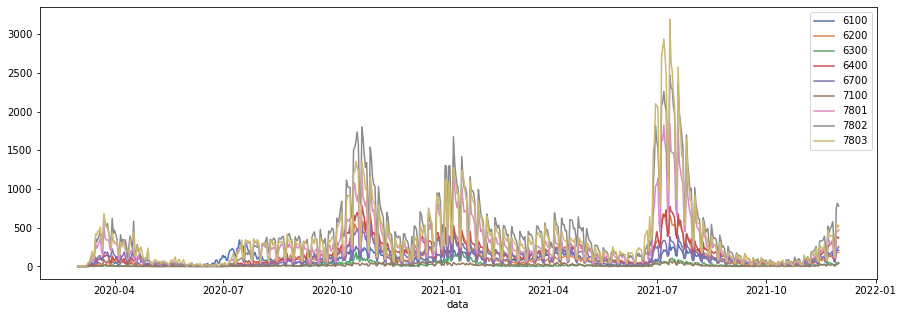

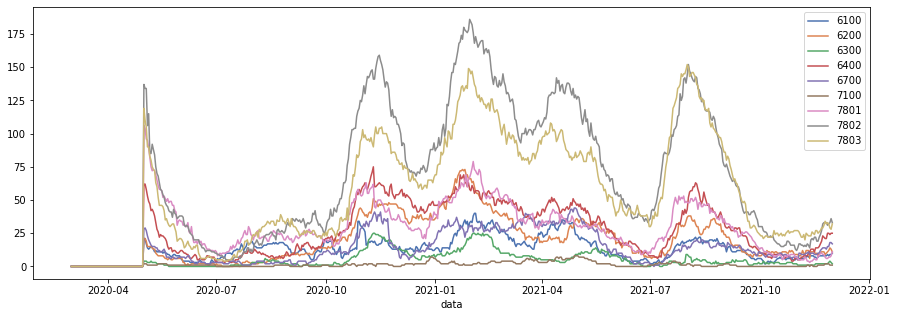

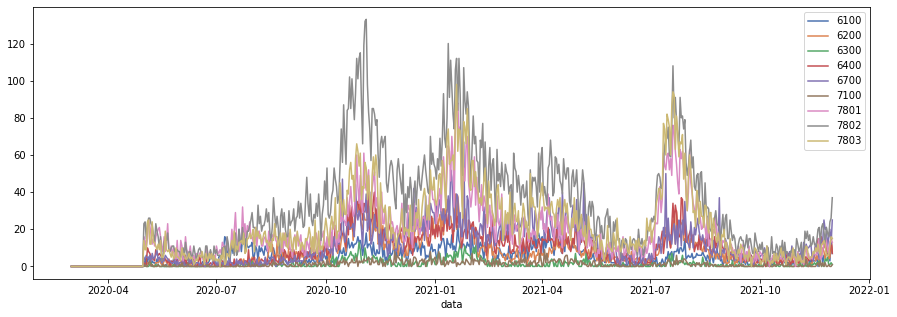

In [23]:
d1Lim = pd.Timestamp(2021, 12, 2)
d1Train = pd.Timestamp(2021, 10, 1)
regions = dfInc["regiosanitariacodi"].copy()
regions = regions.unique()
print(regions)
plt.figure(figsize=(15,5))
sns.lineplot(x="data",y="casos_confirmat", hue="regiosanitariacodi", palette=sns.color_palette("deep", 9),
             data=dfInc.loc[dfInc["data"]<d1Lim])
plt.ylabel("")
#plt.axvline(d1Train,ls="--",color="black")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
sns.lineplot(x="data",y="ingressats_critic", hue="regiosanitariacodi", palette=sns.color_palette("deep", 9),
             data=dfInc.loc[dfInc["data"]<d1Lim])
#plt.axvline(d1Train,ls="--",color="black")
plt.ylabel("")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
sns.lineplot(x="data",y="ingressos_total", hue="regiosanitariacodi", palette=sns.color_palette("deep", 9),
             data=dfInc.loc[dfInc["data"]<d1Lim])
plt.ylabel("")
#plt.axvline(d1Train,ls="--",color="black")
plt.legend()
plt.show()

In [24]:
# Tranform data
#dfInc_r_0 = dfInc[dfInc["regiosanitariacodi"]==0][["data","ingressats_critic"]]
dfInc_r_7803 = dfInc[dfInc["regiosanitariacodi"]==7803][["data","ingressos_total","casos_confirmat"]]
dfInc_r_6700 = dfInc[dfInc["regiosanitariacodi"]==6700][["data","ingressos_total","casos_confirmat"]]
dfInc_r_7801 = dfInc[dfInc["regiosanitariacodi"]==7801][["data","ingressos_total","casos_confirmat"]]
dfInc_r_6400 = dfInc[dfInc["regiosanitariacodi"]==6400][["data","ingressos_total","casos_confirmat"]]
dfInc_r_7802 = dfInc[dfInc["regiosanitariacodi"]==7802][["data","ingressos_total","casos_confirmat"]]
dfInc_r_6200 = dfInc[dfInc["regiosanitariacodi"]==6200][["data","ingressos_total","casos_confirmat"]]
dfInc_r_6100 = dfInc[dfInc["regiosanitariacodi"]==6100][["data","ingressos_total","casos_confirmat"]]
dfInc_r_7100 = dfInc[dfInc["regiosanitariacodi"]==7100][["data","ingressos_total","casos_confirmat"]]
dfInc_r_6300 = dfInc[dfInc["regiosanitariacodi"]==6300][["data","ingressos_total","casos_confirmat"]]
print(dfInc_r_7803.shape,dfInc_r_6700.shape,dfInc_r_7801.shape)

#dfInc = pd.merge(dfInc_r_0,dfInc_r_7803,how="left", on="data",suffixes=("_r_0","_r_7803"))
dfInc = pd.merge(dfInc_r_7803,dfInc_r_6700,how="left", on="data",suffixes=("_r_7803","_r_6700"))
dfInc = pd.merge(dfInc,dfInc_r_7801,how="left", on="data",suffixes=("_r_6700","_r_7801"))
dfInc = pd.merge(dfInc,dfInc_r_6400,how="left", on="data",suffixes=("_r_7801","_r_6400"))
dfInc = pd.merge(dfInc,dfInc_r_7802,how="left", on="data",suffixes=("_r_6400","_r_7802"))
dfInc = pd.merge(dfInc,dfInc_r_6200,how="left", on="data",suffixes=("_r_7802","_r_6200"))
dfInc = pd.merge(dfInc,dfInc_r_6100,how="left", on="data",suffixes=("_r_6200","_r_6100"))
dfInc = pd.merge(dfInc,dfInc_r_7100,how="left", on="data",suffixes=("_r_6100","_r_7100"))
dfInc = pd.merge(dfInc,dfInc_r_6300,how="left", on="data",suffixes=("_r_7100","_r_6300"))
dfInc = pd.merge(dfInc,dfInc_r_6300,how="left", on="data",suffixes=("_r_6300","_r_6300_1"))

dfInc = dfInc[['data', 
       'casos_confirmat_r_7803', 'casos_confirmat_r_6700',
       'casos_confirmat_r_7801', 'casos_confirmat_r_6400',
       'casos_confirmat_r_7802', 'casos_confirmat_r_6200',
       'casos_confirmat_r_6100', 'casos_confirmat_r_7100',
       'casos_confirmat_r_6300',
       'ingressos_total_r_7803', 'ingressos_total_r_6700',
       'ingressos_total_r_7801', 'ingressos_total_r_6400',
       'ingressos_total_r_7802', 'ingressos_total_r_6200',
       'ingressos_total_r_6100', 'ingressos_total_r_7100',
       'ingressos_total_r_6300'               
              ]]
print(dfInc.shape)
print(dfInc.columns)
dfInc.tail(50)

(731, 3) (731, 3) (731, 3)
(731, 19)
Index(['data', 'casos_confirmat_r_7803', 'casos_confirmat_r_6700',
       'casos_confirmat_r_7801', 'casos_confirmat_r_6400',
       'casos_confirmat_r_7802', 'casos_confirmat_r_6200',
       'casos_confirmat_r_6100', 'casos_confirmat_r_7100',
       'casos_confirmat_r_6300', 'ingressos_total_r_7803',
       'ingressos_total_r_6700', 'ingressos_total_r_7801',
       'ingressos_total_r_6400', 'ingressos_total_r_7802',
       'ingressos_total_r_6200', 'ingressos_total_r_6100',
       'ingressos_total_r_7100', 'ingressos_total_r_6300'],
      dtype='object')


,data,casos_confirmat_r_7803,casos_confirmat_r_6700,casos_confirmat_r_7801,casos_confirmat_r_6400,casos_confirmat_r_7802,casos_confirmat_r_6200,casos_confirmat_r_6100,casos_confirmat_r_7100,casos_confirmat_r_6300,ingressos_total_r_7803,ingressos_total_r_6700,ingressos_total_r_7801,ingressos_total_r_6400,ingressos_total_r_7802,ingressos_total_r_6200,ingressos_total_r_6100,ingressos_total_r_7100,ingressos_total_r_6300
681,2022-01-11,7188,2321,6469,3174,9920,2520,1517,273,577,40,40,68,38,92,32,13,2,5
682,2022-01-12,6983,2293,5914,3263,9880,2411,1421,283,624,80,36,75,27,95,25,13,3,7
683,2022-01-13,6338,2149,5579,3044,9498,2256,1384,243,489,54,37,72,31,105,20,17,3,4
684,2022-01-14,5973,2191,5344,3151,9342,2220,1294,251,515,68,32,57,29,110,21,18,2,1
685,2022-01-15,4859,1776,3952,2523,7949,1877,1125,227,432,47,35,56,21,87,22,17,2,7
686,2022-01-16,4883,1869,4505,2707,8387,2015,1248,182,519,38,34,46,30,68,16,13,1,5
687,2022-01-17,9118,3456,8552,4872,14557,3495,2015,348,736,51,34,70,34,105,32,20,4,4
688,2022-01-18,8194,3157,7421,4423,13622,3311,1971,348,729,72,63,64,36,116,27,20,5,5
689,2022-01-19,7852,2998,7148,4353,12973,3323,1886,279,669,75,33,75,27,113,29,11,1,3
690,2022-01-20,7140,2607,6519,3952,11411,3317,1841,238,686,69,41,62,35,85,19,10,5,5


In [25]:
#NAN
print(dfInc.isnull().sum(axis=0))
dfInc.fillna(0,inplace=True)
print(dfInc.isnull().sum(axis=0))

data                      0
casos_confirmat_r_7803    0
casos_confirmat_r_6700    0
casos_confirmat_r_7801    0
casos_confirmat_r_6400    0
casos_confirmat_r_7802    0
casos_confirmat_r_6200    0
casos_confirmat_r_6100    0
casos_confirmat_r_7100    0
casos_confirmat_r_6300    0
ingressos_total_r_7803    0
ingressos_total_r_6700    0
ingressos_total_r_7801    0
ingressos_total_r_6400    0
ingressos_total_r_7802    0
ingressos_total_r_6200    0
ingressos_total_r_6100    0
ingressos_total_r_7100    0
ingressos_total_r_6300    0
dtype: int64
data                      0
casos_confirmat_r_7803    0
casos_confirmat_r_6700    0
casos_confirmat_r_7801    0
casos_confirmat_r_6400    0
casos_confirmat_r_7802    0
casos_confirmat_r_6200    0
casos_confirmat_r_6100    0
casos_confirmat_r_7100    0
casos_confirmat_r_6300    0
ingressos_total_r_7803    0
ingressos_total_r_6700    0
ingressos_total_r_7801    0
ingressos_total_r_6400    0
ingressos_total_r_7802    0
ingressos_total_r_6200    0
ingress

In [26]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = [
       'data',
       'casos_confirmat_r_7803', 'casos_confirmat_r_6700',
       'casos_confirmat_r_7801', 'casos_confirmat_r_6400',
       'casos_confirmat_r_7802', 'casos_confirmat_r_6200',
       'casos_confirmat_r_6100', 'casos_confirmat_r_7100',
       'casos_confirmat_r_6300',    
       'ingressos_total_r_7803', 'ingressos_total_r_6700',
       'ingressos_total_r_7801', 'ingressos_total_r_6400',
       'ingressos_total_r_7802', 'ingressos_total_r_6200',
       'ingressos_total_r_6100', 'ingressos_total_r_7100',
       'ingressos_total_r_6300'
]
print(cols)
dfInc = dfInc[cols]
for k in range(1,len(cols)):
    print(k,cols[k])
    dfInc[cols[k]] = pd.to_numeric(dfInc[cols[k]])
    zn = []
    for i in range(dfInc.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfInc.iloc[i-j,k]
        zn.append(acc/7)

    dfInc[cols[k] + "_7"] = zn
    
dfInc = dfInc[["data",
               'casos_confirmat_r_7803', 'casos_confirmat_r_6700',
               'casos_confirmat_r_7801', 'casos_confirmat_r_6400', 'casos_confirmat_r_7802',
               'casos_confirmat_r_6200', 'casos_confirmat_r_6100', 'casos_confirmat_r_7100',
               'casos_confirmat_r_6300',
               'casos_confirmat_r_7803_7', 'casos_confirmat_r_6700_7',
               'casos_confirmat_r_7801_7', 'casos_confirmat_r_6400_7', 'casos_confirmat_r_7802_7',
               'casos_confirmat_r_6200_7', 'casos_confirmat_r_6100_7', 'casos_confirmat_r_7100_7',
               'casos_confirmat_r_6300_7',         
               'ingressos_total_r_7803', 'ingressos_total_r_6700',
               'ingressos_total_r_7801', 'ingressos_total_r_6400', 'ingressos_total_r_7802',
               'ingressos_total_r_6200', 'ingressos_total_r_6100', 'ingressos_total_r_7100',
               'ingressos_total_r_6300',
               'ingressos_total_r_7803_7', 'ingressos_total_r_6700_7',
               'ingressos_total_r_7801_7', 'ingressos_total_r_6400_7', 'ingressos_total_r_7802_7',
               'ingressos_total_r_6200_7', 'ingressos_total_r_6100_7', 'ingressos_total_r_7100_7',
               'ingressos_total_r_6300_7']]
print(dfInc.shape)
dfInc

['data', 'casos_confirmat_r_7803', 'casos_confirmat_r_6700', 'casos_confirmat_r_7801', 'casos_confirmat_r_6400', 'casos_confirmat_r_7802', 'casos_confirmat_r_6200', 'casos_confirmat_r_6100', 'casos_confirmat_r_7100', 'casos_confirmat_r_6300', 'ingressos_total_r_7803', 'ingressos_total_r_6700', 'ingressos_total_r_7801', 'ingressos_total_r_6400', 'ingressos_total_r_7802', 'ingressos_total_r_6200', 'ingressos_total_r_6100', 'ingressos_total_r_7100', 'ingressos_total_r_6300']
1 casos_confirmat_r_7803
2 casos_confirmat_r_6700
3 casos_confirmat_r_7801
4 casos_confirmat_r_6400
5 casos_confirmat_r_7802
6 casos_confirmat_r_6200
7 casos_confirmat_r_6100
8 casos_confirmat_r_7100
9 casos_confirmat_r_6300
10 ingressos_total_r_7803
11 ingressos_total_r_6700
12 ingressos_total_r_7801
13 ingressos_total_r_6400
14 ingressos_total_r_7802
15 ingressos_total_r_6200
16 ingressos_total_r_6100
17 ingressos_total_r_7100
18 ingressos_total_r_6300
(731, 37)


,data,casos_confirmat_r_7803,casos_confirmat_r_6700,casos_confirmat_r_7801,casos_confirmat_r_6400,casos_confirmat_r_7802,casos_confirmat_r_6200,casos_confirmat_r_6100,casos_confirmat_r_7100,casos_confirmat_r_6300,...,ingressos_total_r_6300,ingressos_total_r_7803_7,ingressos_total_r_6700_7,ingressos_total_r_7801_7,ingressos_total_r_6400_7,ingressos_total_r_7802_7,ingressos_total_r_6200_7,ingressos_total_r_6100_7,ingressos_total_r_7100_7,ingressos_total_r_6300_7
0,2020-03-01,4,0,0,2,4,0,0,0,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-03-02,2,1,1,0,0,0,0,0,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-03-03,5,1,3,1,2,0,0,0,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-03-04,3,1,1,1,1,0,0,0,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2020-03-05,10,2,2,2,3,0,0,0,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2022-02-25,592,226,492,324,854,402,157,33,103,...,4,17.857143,17.000000,16.142857,9.714286,42.857143,11.142857,6.428571,2.000000,2.857143
727,2022-02-26,371,148,343,211,555,343,84,29,71,...,2,16.857143,16.714286,14.428571,9.000000,42.000000,11.000000,6.000000,1.857143,2.428571
728,2022-02-27,329,145,289,247,493,314,96,36,45,...,0,14.714286,16.142857,15.000000,9.000000,43.000000,10.714286,5.142857,1.000000,2.285714
729,2022-02-28,616,239,629,375,897,469,162,36,85,...,1,14.428571,15.142857,14.142857,8.714286,44.571429,9.714286,5.285714,0.857143,2.142857


In [27]:
#Forecasting predictions!!

In [28]:
mapRegId = {
 '0000': 'No classificat',
 '7803': 'BARCELONA CIUTAT',
 '6700': 'CATALUNYA CENTRAL',
 '7801': 'METROPOLITANA SUD',
 '6400': 'GIRONA',
 '7802': 'METROPOLITANA NORD',
 '6200': 'CAMP DE TARRAGONA',
 '6100': 'LLEIDA',
 '7100': 'ALT PIRINEU I ARAN',
 '6300': "TERRES DE L'EBRE"    
}

In [29]:
selCodisReg = ['6100', '6200', '6300', '6400', '6700', '7100', '7801', '7802','7803']

In [30]:
modelNames = [
    #"ingressos_total_best_model_region_vacc_mean7.02122021.new",
    "ingressos_total_best_model_region_shallow.02122021.",
    "ingressos_total_best_model_region_vacc_shallow.02122021.",
    "ingressos_total_best_model_region_vacc_mean7.02122021."
]

In [31]:
#Get cls

In [32]:
preds_all = []
for cls in modelNames:
    for cod in selCodisReg:

        fname = cls+cod   
        print("\n" + str(cod) + " " + mapRegId[str(cod)] + "\n")
        print(fname)


        #Read data
        dfAll = pd.merge(dfInc[["data",'ingressos_total_r_'+cod,'ingressos_total_r_'+cod+'_7',
                                'casos_confirmat_r_'+cod,'casos_confirmat_r_'+cod+'_7'
                               ]],
                         dfVacAll[["data","recompte_r_"+cod+"_v1","recompte_r_"+cod+"_v2",
                                   "recompte_r_"+cod+"_v1_7","recompte_r_"+cod+"_v2_7"]], 
                         how="left",on="data",suffixes=("","")
                        )

        #Filter dates
        d1 = pd.Timestamp(2021, 12, 2)
        dfAll["data"] = pd.to_datetime(dfAll["data"])
        dfAll = dfAll[dfAll["data"]<=d1]
        dfAll.fillna(0,inplace=True)

        #Remove last days 
        dfAll = dfAll.iloc[:-1]
        dateIni = str(dfAll.iloc[-1]["data"])[:-9]
        dateFi = str(dfAll.iloc[0]["data"])[:-9]
        print(dateIni, dateFi)

        #Convert data to format (rows,timepoints,features)
        if "new" in fname:
            cols = [
               'ingressos_total_r_'+cod,'ingressos_total_r_'+cod+'_7',
               'recompte_r_'+cod+'_v1','recompte_r_'+cod+'_v1_7', 
               'recompte_r_'+cod+'_v2','recompte_r_'+cod+'_v2_7']
        elif "mean7" in fname:
            cols = [
               'ingressos_total_r_'+cod,'ingressos_total_r_'+cod+'_7', 
               'casos_confirmat_r_'+cod,'casos_confirmat_r_'+cod+'_7',
               'recompte_r_'+cod+'_v1','recompte_r_'+cod+'_v1_7', 
               'recompte_r_'+cod+'_v2','recompte_r_'+cod+'_v2_7']
        elif "vacc_shallow" in fname:
            cols = [
               'ingressos_total_r_'+cod,
               'recompte_r_'+cod+'_v1','recompte_r_'+cod+'_v2']
        elif "shallow" in fname:
            cols = [
               'ingressos_total_r_'+cod]            
        
        print(cols)
        ncols=len(cols)
        res = series_to_supervised(dfAll.loc[:,cols].values,21,21,dropnan=False)   

        #Patition train/test
        data_X = res.iloc[:,:(21*ncols)].values.reshape(-1,21,ncols)
        real_all = res.iloc[:,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)  

        # normalize features
        scalers_X = []
        print("\nSHAPE:\n",data_X.shape)
        for i in range(data_X.shape[-1]):
            print(fname + "_scaler_tr_X_" + str(i)+'.pkl')
            scaler = load(open("models/"+ fname + "_scaler_tr_X_" + str(i)+'.pkl', 'rb'))
            data_X[:,:,i] = scaler.transform(data_X[:,:,i])
        scaler_y = load(open("models/"+ fname + "_scaler_tr_Y.pkl", 'rb'))

        #Evaluate
        preds_region = []
        for cc in range(5):
            print("Loading...", "models/"+ fname + "_" + str(cc) +'.h5')
            model = tf.keras.models.load_model("models/"+ fname + "_" + str(cc) +'.h5')
            preds = model.predict(data_X)
            preds_region.append(scaler_y.inverse_transform(preds))
        preds_all.append(preds_region)
        preds_region = np.array(preds_region).reshape(5,data_X.shape[0],data_X.shape[1])
        np.save(os.getcwd()+"/results/res_"+ fname +'.npy', preds_region)


6100 LLEIDA

ingressos_total_best_model_region_shallow.02122021.6100
2021-12-01 2020-03-01
['ingressos_total_r_6100']

SHAPE:
 (641, 21, 1)
ingressos_total_best_model_region_shallow.02122021.6100_scaler_tr_X_0.pkl
Loading... models/ingressos_total_best_model_region_shallow.02122021.6100_0.h5
Loading... models/ingressos_total_best_model_region_shallow.02122021.6100_1.h5
Loading... models/ingressos_total_best_model_region_shallow.02122021.6100_2.h5
Loading... models/ingressos_total_best_model_region_shallow.02122021.6100_3.h5
Loading... models/ingressos_total_best_model_region_shallow.02122021.6100_4.h5

6200 CAMP DE TARRAGONA

ingressos_total_best_model_region_shallow.02122021.6200
2021-12-01 2020-03-01
['ingressos_total_r_6200']

SHAPE:
 (641, 21, 1)
ingressos_total_best_model_region_shallow.02122021.6200_scaler_tr_X_0.pkl
Loading... models/ingressos_total_best_model_region_shallow.02122021.6200_0.h5
Loading... models/ingressos_total_best_model_region_shallow.02122021.6200_1.h5
Loadin

Loading... models/ingressos_total_best_model_region_vacc_shallow.02122021.6400_1.h5
Loading... models/ingressos_total_best_model_region_vacc_shallow.02122021.6400_2.h5
Loading... models/ingressos_total_best_model_region_vacc_shallow.02122021.6400_3.h5
Loading... models/ingressos_total_best_model_region_vacc_shallow.02122021.6400_4.h5

6700 CATALUNYA CENTRAL

ingressos_total_best_model_region_vacc_shallow.02122021.6700
2021-12-01 2020-03-01
['ingressos_total_r_6700', 'recompte_r_6700_v1', 'recompte_r_6700_v2']

SHAPE:
 (641, 21, 3)
ingressos_total_best_model_region_vacc_shallow.02122021.6700_scaler_tr_X_0.pkl
ingressos_total_best_model_region_vacc_shallow.02122021.6700_scaler_tr_X_1.pkl
ingressos_total_best_model_region_vacc_shallow.02122021.6700_scaler_tr_X_2.pkl
Loading... models/ingressos_total_best_model_region_vacc_shallow.02122021.6700_0.h5
Loading... models/ingressos_total_best_model_region_vacc_shallow.02122021.6700_1.h5
Loading... models/ingressos_total_best_model_region_vacc_s

Loading... models/ingressos_total_best_model_region_vacc_mean7.02122021.6300_1.h5
Loading... models/ingressos_total_best_model_region_vacc_mean7.02122021.6300_2.h5
Loading... models/ingressos_total_best_model_region_vacc_mean7.02122021.6300_3.h5
Loading... models/ingressos_total_best_model_region_vacc_mean7.02122021.6300_4.h5

6400 GIRONA

ingressos_total_best_model_region_vacc_mean7.02122021.6400
2021-12-01 2020-03-01
['ingressos_total_r_6400', 'ingressos_total_r_6400_7', 'casos_confirmat_r_6400', 'casos_confirmat_r_6400_7', 'recompte_r_6400_v1', 'recompte_r_6400_v1_7', 'recompte_r_6400_v2', 'recompte_r_6400_v2_7']

SHAPE:
 (641, 21, 8)
ingressos_total_best_model_region_vacc_mean7.02122021.6400_scaler_tr_X_0.pkl
ingressos_total_best_model_region_vacc_mean7.02122021.6400_scaler_tr_X_1.pkl
ingressos_total_best_model_region_vacc_mean7.02122021.6400_scaler_tr_X_2.pkl
ingressos_total_best_model_region_vacc_mean7.02122021.6400_scaler_tr_X_3.pkl
ingressos_total_best_model_region_vacc_mean7.0

Loading... models/ingressos_total_best_model_region_vacc_mean7.02122021.7803_2.h5
Loading... models/ingressos_total_best_model_region_vacc_mean7.02122021.7803_3.h5
Loading... models/ingressos_total_best_model_region_vacc_mean7.02122021.7803_4.h5


In [33]:
# EVALUATION 
# Validation: 2021-03-27
# Test: 2021-05-27
# ALL data: 2020-03-01 2021-11-30 640 640
# TEST data: 2021-10-01 2021-11-30 61


ingressos_total_best_model_region_shallow.02122021.
6100
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 1.74 MAPE: 0.79 CUM-MAE: 17.61 CUM-MAPE: 0.22 R2: 0.45
7 56 MAE: 1.79 MAPE: 0.82 CUM-MAE: 19.15 CUM-MAPE: 0.39 R2: 0.11
14 49 MAE: 1.78 MAPE: 0.66 CUM-MAE: 5.65 CUM-MAPE: 0.08 R2: -0.15
21 42 MAE: 1.89 MAPE: 0.76 CUM-MAE: 8.96 CUM-MAPE: 0.18 R2: -0.26
ALL 62 MAE: 1.28 MAPE: 0.27 CUM-MAE: 12.33 CUM-MAPE: 0.14 R2: 0.72
6200
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 2.4 MAPE: 1.05 CUM-MAE: 59.11 CUM-MAPE: 0.7 R2: 0.43
7 56 MAE: 2.26 MAPE: 0.97 CUM-MAE: 50.17 CUM-MAPE: 0.54 R2: 0.52
14 49 MAE: 2.66 MAPE: 1.18 CUM-MAE: 57.59 CUM-MAPE: 0.67 R2: -0.07
21 42 MAE: 2.85 MAPE: 1.3 CUM-MAE: 54.35 CUM-MAPE: 0.74 R2: -0.03
ALL 62 MAE: 1.88 MAPE: 0.48 CUM-MAE: 56.1 CUM-MAPE: 0.55 R2: 0.37
6300
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 0.62 MAPE: 0.38 CUM-MAE: 15.62 CUM-MAP

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


14 49 MAE: 4.1 MAPE: 0.6 CUM-MAE: 28.44 CUM-MAPE: 0.23 R2: 0.69
21 42 MAE: 4.54 MAPE: 0.65 CUM-MAE: 26.28 CUM-MAPE: 0.28 R2: 0.46
ALL 62 MAE: 3.77 MAPE: 0.34 CUM-MAE: 42.25 CUM-MAPE: 0.29 R2: 0.85
7100
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 0.61 MAPE: 0.47 CUM-MAE: 19.73 CUM-MAPE: 0.58 R2: -0.08
7 56 MAE: 0.53 MAPE: 0.41 CUM-MAE: 14.36 CUM-MAPE: 0.49 R2: -0.07
14 49 MAE: 0.48 MAPE: 0.35 CUM-MAE: 11.31 CUM-MAPE: 0.43 R2: 0.1
21 42 MAE: 0.45 MAPE: 0.3 CUM-MAE: 8.12 CUM-MAPE: 0.36 R2: 0.01
ALL 62 MAE: 0.47 MAPE: 0.39 CUM-MAE: 15.55 CUM-MAPE: 0.46 R2: -0.24
7801
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 2.68 MAPE: 0.85 CUM-MAE: 58.89 CUM-MAPE: 0.36 R2: 0.6
7 56 MAE: 3.15 MAPE: 1.0 CUM-MAE: 77.0 CUM-MAPE: 0.59 R2: 0.48
14 49 MAE: 4.66 MAPE: 1.43 CUM-MAE: 129.28 CUM-MAPE: 1.3 R2: -0.13
21 42 MAE: 6.62 MAPE: 2.16 CUM-MAE: 178.72 CUM-MAPE: 2.12 R2: -0.37
ALL 62 MAE: 2.89 MAPE: 0.56 CUM-MAE: 118.86 CUM-MA

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


ALL 62 MAE: 1.36 MAPE: 0.25 CUM-MAE: 13.42 CUM-MAPE: 0.12 R2: 0.52
6300
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 0.63 MAPE: 0.39 CUM-MAE: 16.29 CUM-MAPE: 0.45 R2: 0.24
7 56 MAE: 0.64 MAPE: 0.39 CUM-MAE: 14.55 CUM-MAPE: 0.42 R2: 0.38
14 49 MAE: 0.55 MAPE: 0.28 CUM-MAE: 9.18 CUM-MAPE: 0.28 R2: 0.22
21 42 MAE: 0.56 MAPE: 0.29 CUM-MAE: 3.34 CUM-MAPE: 0.09 R2: 0.13
ALL 62 MAE: 0.57 MAPE: 0.37 CUM-MAE: 14.59 CUM-MAPE: 0.34 R2: 0.4
6400
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 1.95 MAPE: 0.61 CUM-MAE: 11.09 CUM-MAPE: 0.14 R2: 0.74
7 56 MAE: 2.53 MAPE: 0.62 CUM-MAE: 17.46 CUM-MAPE: 0.24 R2: 0.56
14 49 MAE: 3.13 MAPE: 0.62 CUM-MAE: 22.77 CUM-MAPE: 0.23 R2: 0.43
21 42 MAE: 3.25 MAPE: 0.49 CUM-MAE: 26.03 CUM-MAPE: 0.16 R2: 0.56
ALL 62 MAE: 2.06 MAPE: 0.28 CUM-MAE: 34.15 CUM-MAPE: 0.19 R2: 0.69
6700
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 3.12 MAPE: 0.57 CUM-MAE: 

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 3.61 MAPE: 1.17 CUM-MAE: 109.91 CUM-MAPE: 0.65 R2: 0.59
7 56 MAE: 3.64 MAPE: 1.17 CUM-MAE: 97.36 CUM-MAPE: 0.7 R2: 0.51
14 49 MAE: 4.65 MAPE: 1.43 CUM-MAE: 125.25 CUM-MAPE: 1.17 R2: 0.15
21 42 MAE: 6.34 MAPE: 2.05 CUM-MAE: 163.97 CUM-MAPE: 1.83 R2: -0.11
ALL 62 MAE: 3.22 MAPE: 0.62 CUM-MAE: 132.04 CUM-MAPE: 0.91 R2: 0.58
7802
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 3.92 MAPE: 0.46 CUM-MAE: 61.95 CUM-MAPE: 0.24 R2: 0.69
7 56 MAE: 4.16 MAPE: 0.44 CUM-MAE: 34.73 CUM-MAPE: 0.2 R2: 0.73
14 49 MAE: 4.85 MAPE: 0.45 CUM-MAE: 30.97 CUM-MAPE: 0.19 R2: 0.45
21 42 MAE: 5.32 MAPE: 0.47 CUM-MAE: 34.35 CUM-MAPE: 0.29 R2: 0.53
ALL 62 MAE: 3.9 MAPE: 0.25 CUM-MAE: 39.69 CUM-MAPE: 0.19 R2: 0.89
7803
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 2.78 MAPE: 0.82 CUM-MAE: 28.63 CUM-MAPE: 0.32 R2: 0.51
7 56 MAE: 2.76 MAPE: 0.74 CUM-MAE: 21.84 CUM-MAPE: 0.21 R2: 0.52
14 49 MAE: 2

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


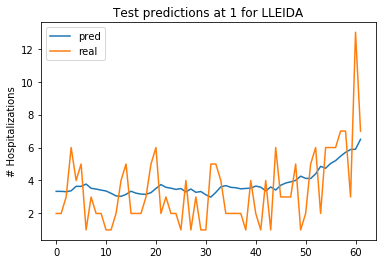

7 56 MAE: 1.6 MAPE: 0.75 CUM-MAE: 12.71 CUM-MAPE: 0.28 R2: 0.59


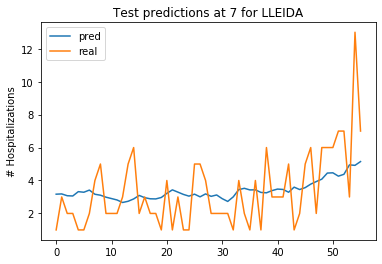

14 49 MAE: 1.67 MAPE: 0.65 CUM-MAE: 3.98 CUM-MAPE: 0.06 R2: 0.6


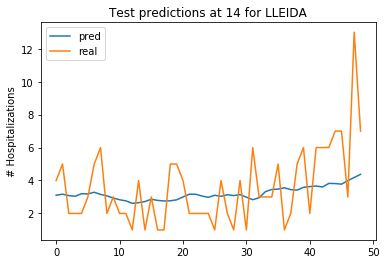

21 42 MAE: 1.89 MAPE: 0.85 CUM-MAE: 14.24 CUM-MAPE: 0.27 R2: 0.41


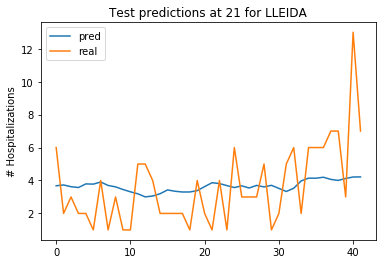

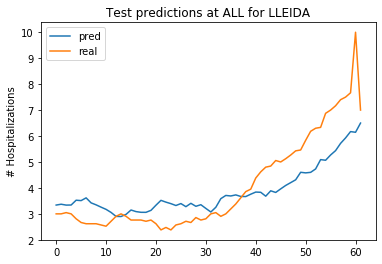

ALL 62 MAE: 0.8 MAPE: 0.2 CUM-MAE: 10.07 CUM-MAPE: 0.14 R2: 0.94
6200
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 1.73 MAPE: 0.69 CUM-MAE: 14.96 CUM-MAPE: 0.2 R2: 0.57


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


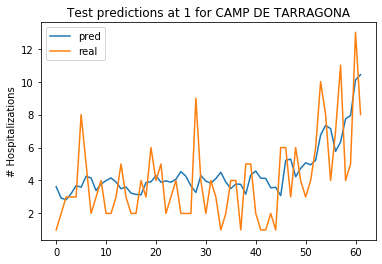

7 56 MAE: 1.53 MAPE: 0.57 CUM-MAE: 6.76 CUM-MAPE: 0.07 R2: 0.65


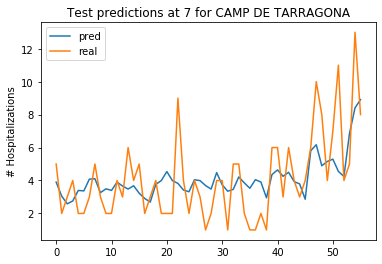

14 49 MAE: 1.77 MAPE: 0.65 CUM-MAE: 7.18 CUM-MAPE: 0.08 R2: 0.55


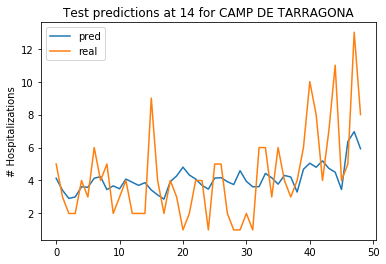

21 42 MAE: 2.03 MAPE: 0.84 CUM-MAE: 20.57 CUM-MAPE: 0.28 R2: 0.48


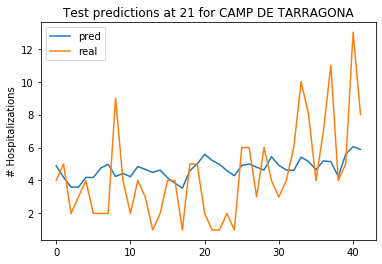

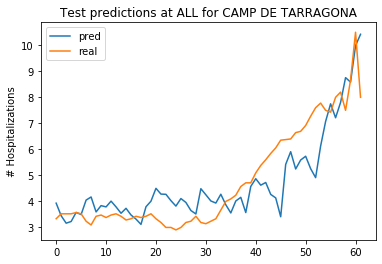

ALL 62 MAE: 0.77 MAPE: 0.17 CUM-MAE: 7.15 CUM-MAPE: 0.07 R2: 0.85
6300
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 0.46 MAPE: 0.29 CUM-MAE: 7.74 CUM-MAPE: 0.22 R2: 0.4


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


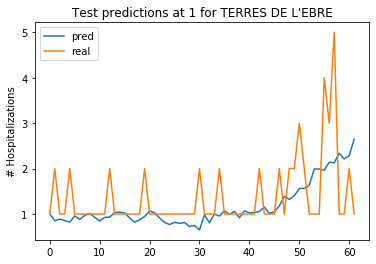

7 56 MAE: 0.47 MAPE: 0.28 CUM-MAE: 5.13 CUM-MAPE: 0.13 R2: 0.33


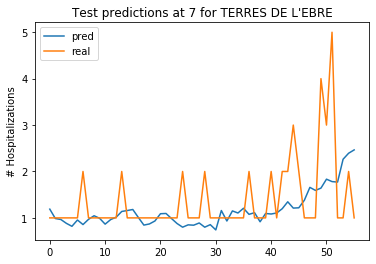

14 49 MAE: 0.49 MAPE: 0.28 CUM-MAE: 2.22 CUM-MAPE: 0.09 R2: 0.29


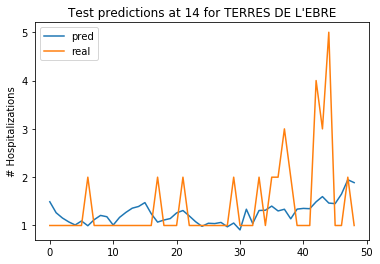

21 42 MAE: 0.71 MAPE: 0.53 CUM-MAE: 7.98 CUM-MAPE: 0.42 R2: 0.19


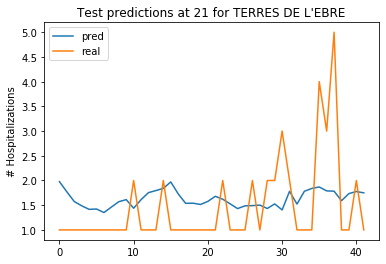

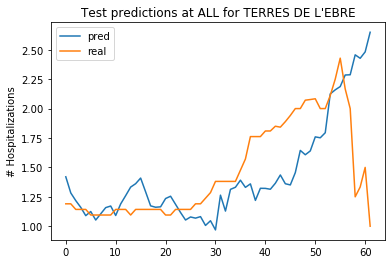

ALL 62 MAE: 0.27 MAPE: 0.19 CUM-MAE: 2.46 CUM-MAPE: 0.06 R2: 0.49
6400
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 2.08 MAPE: 0.66 CUM-MAE: 11.46 CUM-MAPE: 0.15 R2: 0.74


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


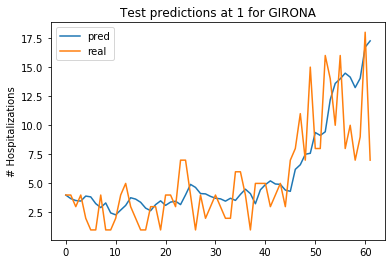

7 56 MAE: 2.37 MAPE: 0.6 CUM-MAE: 13.49 CUM-MAPE: 0.23 R2: 0.64


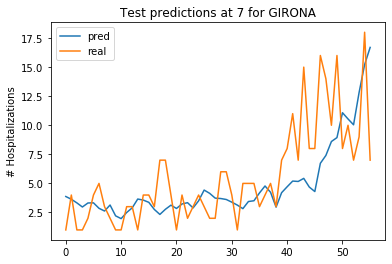

14 49 MAE: 2.88 MAPE: 0.58 CUM-MAE: 23.32 CUM-MAPE: 0.23 R2: 0.59


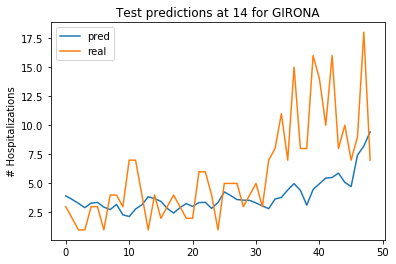

21 42 MAE: 3.29 MAPE: 0.48 CUM-MAE: 33.51 CUM-MAPE: 0.24 R2: 0.56


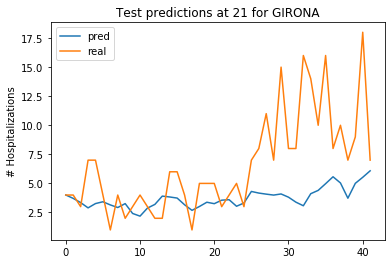

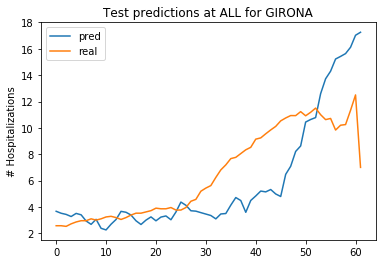

ALL 62 MAE: 2.24 MAPE: 0.3 CUM-MAE: 27.97 CUM-MAPE: 0.16 R2: 0.72
6700
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 2.73 MAPE: 0.49 CUM-MAE: 10.81 CUM-MAPE: 0.05 R2: 0.76


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


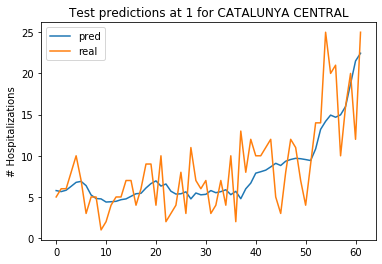

7 56 MAE: 3.44 MAPE: 0.5 CUM-MAE: 32.29 CUM-MAPE: 0.2 R2: 0.73


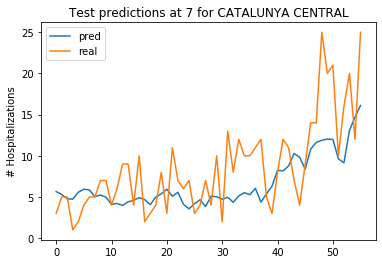

14 49 MAE: 3.94 MAPE: 0.42 CUM-MAE: 50.19 CUM-MAPE: 0.21 R2: 0.71


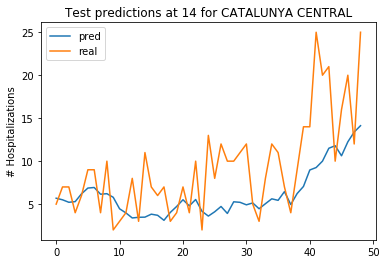

21 42 MAE: 4.89 MAPE: 0.54 CUM-MAE: 41.27 CUM-MAPE: 0.24 R2: 0.43


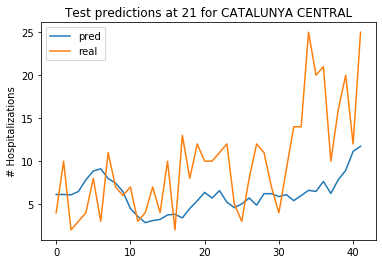

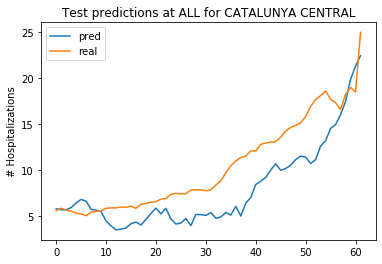

ALL 62 MAE: 2.74 MAPE: 0.27 CUM-MAE: 59.57 CUM-MAPE: 0.19 R2: 0.9
7100
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 0.53 MAPE: 0.41 CUM-MAE: 16.86 CUM-MAPE: 0.5 R2: 0.05


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


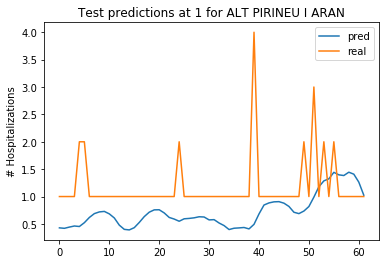

7 56 MAE: 0.54 MAPE: 0.43 CUM-MAE: 14.33 CUM-MAPE: 0.47 R2: 0.01


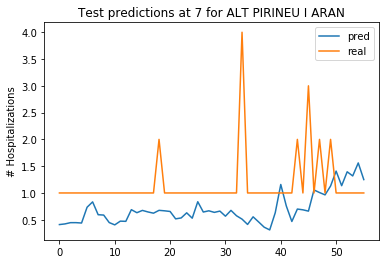

14 49 MAE: 0.56 MAPE: 0.42 CUM-MAE: 13.26 CUM-MAPE: 0.48 R2: -0.11


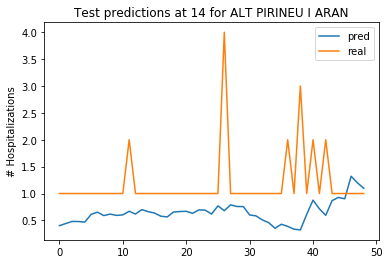

21 42 MAE: 0.61 MAPE: 0.45 CUM-MAE: 12.31 CUM-MAPE: 0.5 R2: -0.0


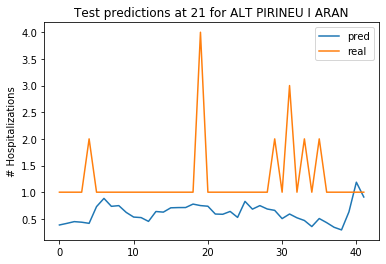

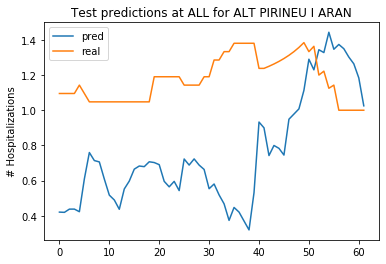

ALL 62 MAE: 0.49 MAPE: 0.41 CUM-MAE: 16.49 CUM-MAPE: 0.48 R2: -0.13
7801
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 2.38 MAPE: 0.71 CUM-MAE: 36.63 CUM-MAPE: 0.21 R2: 0.67


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


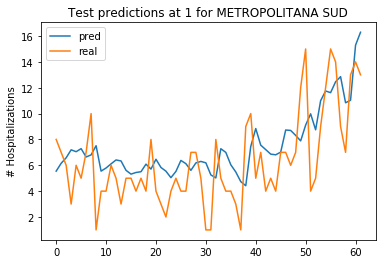

7 56 MAE: 3.09 MAPE: 0.95 CUM-MAE: 71.3 CUM-MAPE: 0.48 R2: 0.7


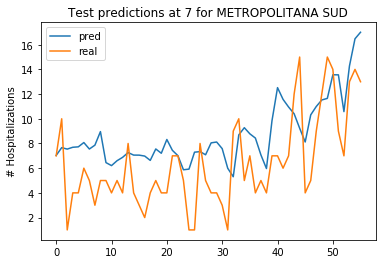

14 49 MAE: 3.37 MAPE: 1.04 CUM-MAE: 83.61 CUM-MAPE: 0.76 R2: 0.72


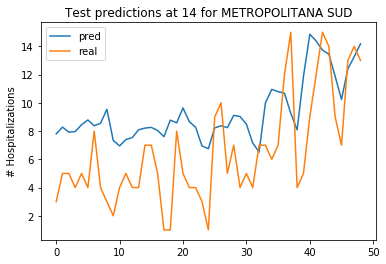

21 42 MAE: 3.61 MAPE: 1.19 CUM-MAE: 83.93 CUM-MAPE: 0.96 R2: 0.75


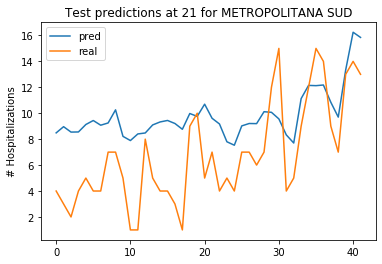

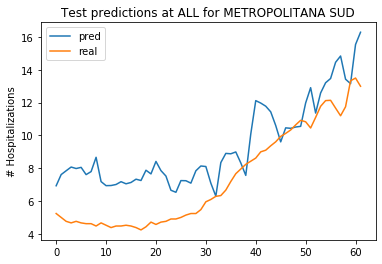

ALL 62 MAE: 2.1 MAPE: 0.37 CUM-MAE: 75.3 CUM-MAPE: 0.49 R2: 0.92
7802
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 4.0 MAPE: 0.5 CUM-MAE: 76.93 CUM-MAPE: 0.26 R2: 0.73


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


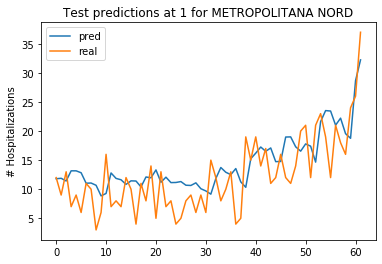

7 56 MAE: 3.53 MAPE: 0.43 CUM-MAE: 47.57 CUM-MAPE: 0.21 R2: 0.79


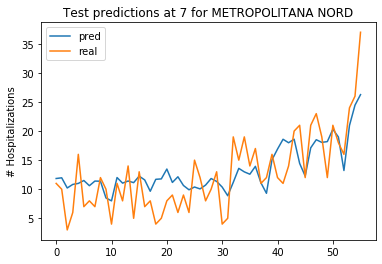

14 49 MAE: 4.19 MAPE: 0.38 CUM-MAE: 20.37 CUM-MAPE: 0.09 R2: 0.69


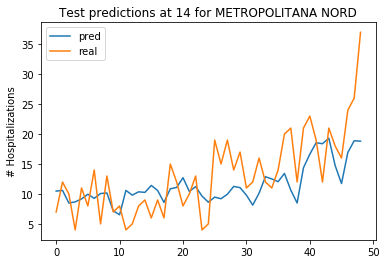

21 42 MAE: 4.88 MAPE: 0.37 CUM-MAE: 36.03 CUM-MAPE: 0.14 R2: 0.81


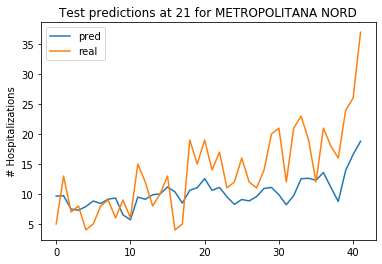

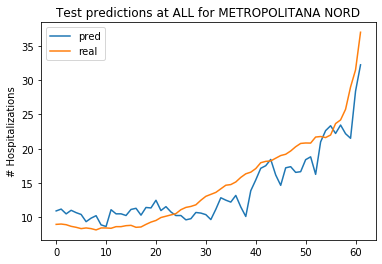

ALL 62 MAE: 2.21 MAPE: 0.16 CUM-MAE: 22.44 CUM-MAPE: 0.12 R2: 0.94
7803
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62
1 62 MAE: 2.94 MAPE: 1.0 CUM-MAE: 70.42 CUM-MAPE: 0.59 R2: 0.66


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


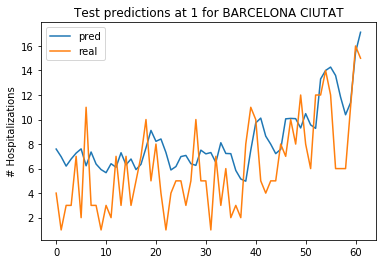

7 56 MAE: 2.7 MAPE: 0.85 CUM-MAE: 53.59 CUM-MAPE: 0.38 R2: 0.68


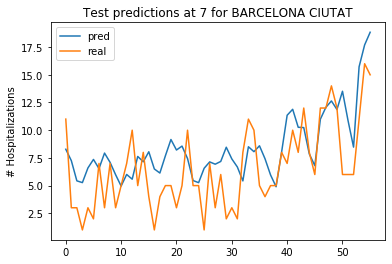

14 49 MAE: 2.19 MAPE: 0.55 CUM-MAE: 5.65 CUM-MAPE: 0.09 R2: 0.67


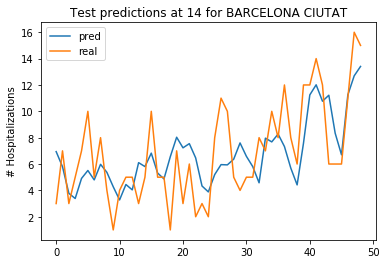

21 42 MAE: 2.12 MAPE: 0.54 CUM-MAE: 9.06 CUM-MAPE: 0.11 R2: 0.73


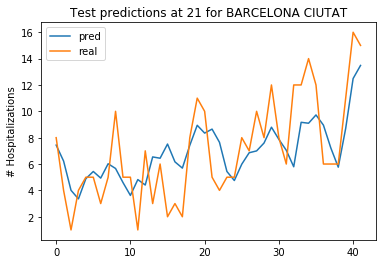

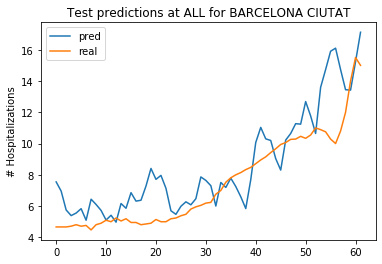

ALL 62 MAE: 1.44 MAPE: 0.21 CUM-MAE: 33.12 CUM-MAPE: 0.23 R2: 0.88


,cls,region,dayPred,num,mae,mape,mae_s,mape_s,maeAcc,mapeAcc,r2
0,ingressos_total_best_model_region_shallow.0212...,6100,1,62,1.74,0.79,1.24,0.79,17.61,0.22,0.45
1,ingressos_total_best_model_region_shallow.0212...,6100,7,62,1.79,0.82,1.37,0.81,19.15,0.39,0.11
2,ingressos_total_best_model_region_shallow.0212...,6100,14,62,1.78,0.66,1.56,0.63,5.65,0.08,-0.15
3,ingressos_total_best_model_region_shallow.0212...,6100,21,62,1.89,0.76,1.58,0.75,8.96,0.18,-0.26
4,ingressos_total_best_model_region_shallow.0212...,6100,-1,62,1.28,0.27,1.25,0.14,12.33,0.14,0.72
...,...,...,...,...,...,...,...,...,...,...,...
130,ingressos_total_best_model_region_vacc_mean7.0...,7803,1,62,2.94,1.00,1.84,1.43,70.42,0.59,0.66
131,ingressos_total_best_model_region_vacc_mean7.0...,7803,7,62,2.70,0.85,1.90,1.23,53.59,0.38,0.68
132,ingressos_total_best_model_region_vacc_mean7.0...,7803,14,62,2.19,0.55,1.52,0.93,5.65,0.09,0.67
133,ingressos_total_best_model_region_vacc_mean7.0...,7803,21,62,2.12,0.54,1.58,0.83,9.06,0.11,0.73


In [34]:
plot = True
perfAll = []
for cls in modelNames[:]:
    print()
    print(cls)
    for cod in selCodisReg:
        print(cod)
        
        #Read data
        dfAll = pd.merge(dfInc[["data",'ingressos_total_r_'+cod,'ingressos_total_r_'+cod+'_7',
                                'casos_confirmat_r_'+cod,'casos_confirmat_r_'+cod+'_7'
                               ]],
                         dfVacAll[["data","recompte_r_"+cod+"_v1","recompte_r_"+cod+"_v2",
                                   "recompte_r_"+cod+"_v1_7","recompte_r_"+cod+"_v2_7"]], 
                         how="left",on="data",suffixes=("","")
                        )
        dfAll.fillna(0,inplace=True)

        #Filter dates
        d1 = pd.Timestamp(2021, 12, 2)
        dfAll["data"] = pd.to_datetime(dfAll["data"])
        dfAll = dfAll[dfAll["data"]<=d1]
        
        dfAll = dfAll.iloc[:-1]
        dateFi = str(dfAll.iloc[-1]["data"])[:-9]
        dateIni = str(dfAll.iloc[0]["data"])[:-9]
        
        #Preds data
        fname = cls+cod
        res = np.load("results/res_"+ fname +'.npy')
        resMean = np.nanmean(res, axis=0)
        resMean[np.isnan(resMean)]=0
        resMean[resMean<0]=0
        
        print("ALL data:", dateIni, dateFi, len(dfAll),len(resMean))
        
        #Performance
        #ctte = dateIni
        #ctte = "2021-05-27"
        ctte = "2021-10-01"
        dayIni = dfAll[dfAll.iloc[:,0]>=ctte].iloc[0,0]
        ini = dfAll.iloc[:,0]>=ctte
        real = dfAll.loc[ini]
        real = real.iloc[:,1].astype(float)
        real[real==0]=1 #To avoid errors (div_zero)!!
        pred = resMean[ini,:].astype(float)

        print("TEST data:", ctte, dateFi, len(pred))  
        
        for j in [0,6,13,20]:        
            result = []          
            for i in range(pred.shape[0]):
                if i+j < len(real):
                    p = pred[i,j]
                    r = real.iloc[i+j]
                    result.append([dayIni+timedelta(days=j)+timedelta(days=j),i,j,p,r])
            result = np.array(result)
        
            #Daily
            mae = np.mean(np.abs(result[:,4]-result[:,3]))
            mape = np.mean(np.abs(result[:,4]-result[:,3])/(result[:,4]+1e-5))
            mae_s = np.std(np.abs(result[:,4]-result[:,3]))
            mape_s = np.std(np.abs(result[:,4]-result[:,3])/(result[:,4]+1e-5))            
            r2 = np.corrcoef(result[:,4].astype(float),result[:,3].astype(float))[0,1]
            
            #CumSum
            realAcc = np.cumsum(result[:,4])
            predAcc = np.cumsum(result[:,3])
            maeAcc = np.mean(np.abs(realAcc-predAcc))
            mapeAcc = np.mean(np.abs(realAcc-predAcc)/(realAcc+1e-5))
                
            print(j+1, len(result), 
                  "MAE:",np.round(mae,2),
                  "MAPE:",np.round(mape,2),
                  "CUM-MAE:",np.round(maeAcc,2),
                  "CUM-MAPE:", np.round(mapeAcc,2),
                  "R2:", np.round(r2,2)
                 )
            
            if mapeAcc > 1000:
                print(realAcc)
                print(predAcc)
                break
                
            if plot and j in [0,6,13,20] and cls == 'ingressos_total_best_model_region_vacc_mean7.02122021.':
                plt.plot(result[:,3],label="pred")
                plt.plot(result[:,4],label="real")
                plt.title("Test predictions at " + str(j+1) + " for "+str(mapRegId[cod]))
                plt.ylabel("# Hospitalizations")
                plt.legend()
                plt.show()
                
            perfAll.append([cls,cod,j+1,len(real), np.round(mae,2), np.round(mape,2),
                            np.round(mae_s,2), np.round(mape_s,2),
                            np.round(maeAcc,2),np.round(mapeAcc,2),np.round(r2,2)])

        #Performance of summing all 21 predictions during the test period
        result = []
        for i in range(pred.shape[0]):            
            p=0
            r=0
            dim=0     
            for j in range(21):
                if i+j < len(real):
                    p += pred[i,j]
                    r += real.iloc[i+j]
                    dim += 1
            result.append([dayIni+timedelta(days=j)+timedelta(days=j),i,p/dim,r/dim])
            
        result = np.array(result)
        if cls == 'ingressos_total_best_model_region_vacc_mean7.02122021.':
            plt.plot(result[:,2],label="pred")
            plt.plot(result[:,3],label="real")
            plt.title("Test predictions at ALL for "+str(mapRegId[cod]))
            plt.ylabel("# Hospitalizations")
            plt.legend()
            plt.show()
        
        #Daily
        mae = np.mean(np.abs(result[:,3]-result[:,2]))
        mape = np.mean(np.abs(result[:,3]-result[:,2])/(result[:,3]+1e-5))
        mae_s = np.std(np.abs(result[:,3]-result[:,2]))
        mape_s = np.std(np.abs(result[:,3]-result[:,2])/(result[:,3]+1e-5))         
        r2 = np.corrcoef(result[:,3].astype(float),result[:,2].astype(float))[0,1]

        #CumSum
        realAcc = np.cumsum(result[:,3])
        predAcc = np.cumsum(result[:,2])
        maeAcc = np.mean(np.abs(realAcc-predAcc))
        mapeAcc = np.mean(np.abs(realAcc-predAcc)/(realAcc+1e-5))
        
        perfAll.append([cls,cod,-1,len(real), np.round(mae,2), np.round(mape,2),
                            np.round(mae_s,2), np.round(mape_s,2),
                        np.round(maeAcc,2),np.round(mapeAcc,2),np.round(r2,2)]) 
        
        print("ALL", len(result), 
              "MAE:",np.round(mae,2),
              "MAPE:",np.round(mape,2),
              "CUM-MAE:",np.round(maeAcc,2),
              "CUM-MAPE:", np.round(mapeAcc,2),
              "R2:", np.round(r2,2)
             )        
dfPerf = pd.DataFrame(perfAll, columns=["cls","region","dayPred","num","mae","mape","mae_s","mape_s","maeAcc","mapeAcc","r2"])
dfPerf

In [35]:
dfPerf[dfPerf["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."].groupby(["dayPred"]).agg("mean")

,num,mae,mape,mae_s,mape_s,maeAcc,mapeAcc,r2
dayPred,,,,,,,,
-1,62,1.451111,0.253333,1.032222,0.171111,28.285556,0.215556,0.723333
1,62,2.051111,0.617778,1.511111,0.760000,29.420000,0.266667,0.571111
7,62,2.141111,0.595556,1.617778,0.696667,28.574444,0.272222,0.568889
14,62,2.340000,0.552222,1.878889,0.625556,23.308889,0.232222,0.523333
21,62,2.670000,0.643333,2.114444,0.682222,28.766667,0.351111,0.484444


In [280]:
grp = dfPerf[["cls","dayPred","region","r2"]].groupby(["cls","dayPred","region"]).agg(["mean","std"]).reset_index()
grp["r2_m"] = grp["r2"]["mean"]
grp["r2_m"] = grp["r2_m"].astype(float)
pvt = pd.pivot(grp, index=["cls","dayPred"],columns="region",values="r2_m")
#display(pvt)
display(pvt.mean(axis=1).round(2))
display(pvt.std(axis=1).round(2))

cls                                                       dayPred
ingressos_total_best_model_region_shallow.02122021.       -1         0.51
                                                           1         0.48
                                                           7         0.43
                                                           14        0.18
                                                           21        0.09
ingressos_total_best_model_region_vacc_mean7.02122021.    -1         0.72
                                                           1         0.57
                                                           7         0.57
                                                           14        0.52
                                                           21        0.48
ingressos_total_best_model_region_vacc_shallow.02122021.  -1         0.57
                                                           1         0.47
                                              

cls                                                       dayPred
ingressos_total_best_model_region_shallow.02122021.       -1         0.34
                                                           1         0.25
                                                           7         0.25
                                                           14        0.28
                                                           21        0.29
ingressos_total_best_model_region_vacc_mean7.02122021.    -1         0.35
                                                           1         0.23
                                                           7         0.25
                                                           14        0.27
                                                           21        0.27
ingressos_total_best_model_region_vacc_shallow.02122021.  -1         0.36
                                                           1         0.25
                                              

/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

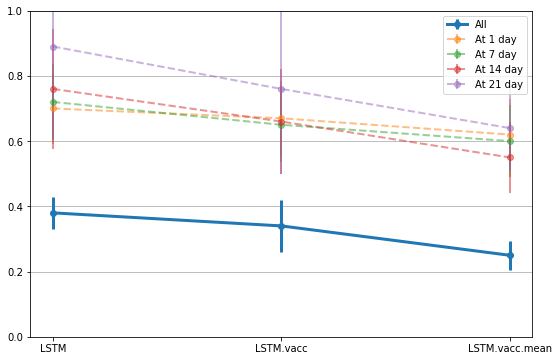

In [231]:
y = pvt.mean(axis=1).round(2).reset_index(drop=False)
y = pd.DataFrame(y)
y["score"] = y[0]
y["cls"][y["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
y.sort_values("cls",inplace=True)
yAll = y[y["dayPred"]==-1]
y1 = y[y["dayPred"]==1]
y7 = y[y["dayPred"]==7]
y14 = y[y["dayPred"]==14]
y21 = y[y["dayPred"]==21]

yAll = yAll["score"]
y1 = y1["score"]
y7 = y7["score"]
y14 = y14["score"]
y21 = y21["score"]

error = pvt.std(axis=1).round(2).reset_index(drop=False)
error = pd.DataFrame(error)
error["score"] = error[0]
error["cls"][error["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
error.sort_values("cls",inplace=True)
errorAll = error[error["dayPred"]==-1]
error1 = error[error["dayPred"]==1]
error7 = error[error["dayPred"]==7]
error14 = error[error["dayPred"]==14]
error21 = error[error["dayPred"]==21]

errorAll = errorAll["score"]
error1 = error1["score"]
error7 = error7["score"]
error14 = error14["score"]
error21 = error21["score"]

plt.figure(figsize=(9,6))
plt.errorbar(range(len(yAll)), yAll, errorAll/2., label="All", linestyle='-', marker='o', linewidth=3)
plt.errorbar(range(len(y1)), y1, error1/2., label="At 1 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y7)), y7, error7/2., label="At 7 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y14)), y14, error14/2., label="At 14 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y21)), y21, error21/2., label="At 21 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)

plt.xticks(range(len(yAll)),["LSTM","LSTM.vacc","LSTM.vacc.mean"])
plt.ylim(0,1)
plt.legend()
plt.grid(axis='y')
plt.show()

In [232]:
grp = dfPerf[["cls","dayPred","region","mae"]].groupby(["cls","dayPred","region"]).agg(["mean","std"]).reset_index()
grp["mae_m"] = grp["mae"]["mean"]
grp["mae_m"] = grp["mae_m"].astype(float)
pvt = pd.pivot(grp, index=["cls","dayPred"],columns="region",values="mae_m")
#display(pvt)
display(pvt.mean(axis=1).round(2))
display(pvt.std(axis=1).round(2))

cls                                                       dayPred
ingressos_total_best_model_region_shallow.02122021.       -1         2.10
                                                           1         2.30
                                                           7         2.46
                                                           14        2.88
                                                           21        3.38
ingressos_total_best_model_region_vacc_mean7.02122021.    -1         1.45
                                                           1         2.05
                                                           7         2.14
                                                           14        2.34
                                                           21        2.67
ingressos_total_best_model_region_vacc_shallow.02122021.  -1         1.87
                                                           1         2.25
                                              

cls                                                       dayPred
ingressos_total_best_model_region_shallow.02122021.       -1         1.21
                                                           1         1.17
                                                           7         1.30
                                                           14        1.79
                                                           21        2.42
ingressos_total_best_model_region_vacc_mean7.02122021.    -1         0.90
                                                           1         1.13
                                                           7         1.17
                                                           14        1.36
                                                           21        1.60
ingressos_total_best_model_region_vacc_shallow.02122021.  -1         1.10
                                                           1         1.19
                                              

/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

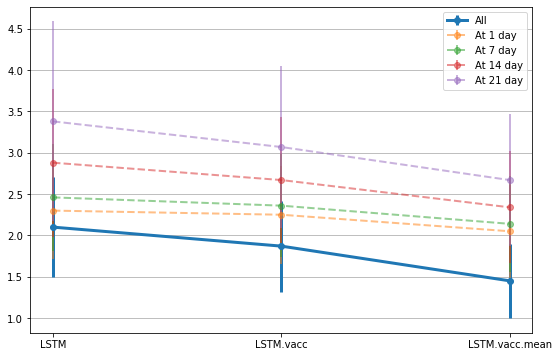

In [233]:
y = pvt.mean(axis=1).round(2).reset_index(drop=False)
y = pd.DataFrame(y)
y["score"] = y[0]
y["cls"][y["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
y.sort_values("cls",inplace=True)
yAll = y[y["dayPred"]==-1]
y1 = y[y["dayPred"]==1]
y7 = y[y["dayPred"]==7]
y14 = y[y["dayPred"]==14]
y21 = y[y["dayPred"]==21]

yAll = yAll["score"]
y1 = y1["score"]
y7 = y7["score"]
y14 = y14["score"]
y21 = y21["score"]

error = pvt.std(axis=1).round(2).reset_index(drop=False)
error = pd.DataFrame(error)
error["score"] = error[0]
error["cls"][error["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
error.sort_values("cls",inplace=True)
errorAll = error[error["dayPred"]==-1]
error1 = error[error["dayPred"]==1]
error7 = error[error["dayPred"]==7]
error14 = error[error["dayPred"]==14]
error21 = error[error["dayPred"]==21]

errorAll = errorAll["score"]
error1 = error1["score"]
error7 = error7["score"]
error14 = error14["score"]
error21 = error21["score"]

plt.figure(figsize=(9,6))
plt.errorbar(range(len(yAll)), yAll, errorAll/2., label="All", linestyle='-', marker='o', linewidth=3)
plt.errorbar(range(len(y1)), y1, error1/2., label="At 1 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y7)), y7, error7/2., label="At 7 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y14)), y14, error14/2., label="At 14 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y21)), y21, error21/2., label="At 21 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)

plt.xticks(range(len(yAll)),["LSTM","LSTM.vacc","LSTM.vacc.mean"])
#plt.ylim(0,1)
plt.legend()
plt.grid(axis='y')
plt.show()

In [37]:
grp = dfPerf[["cls","dayPred","region","mape"]].groupby(["cls","dayPred","region"]).agg(["mean","std"]).reset_index()
grp["mape_m"] = grp["mape"]["mean"]
grp["mape_m"] = grp["mape_m"].astype(float)
pvt = pd.pivot(grp, index=["cls","dayPred"],columns="region",values="mape_m")
#display(pvt)
display(pvt.mean(axis=1).round(2))
display(pvt.std(axis=1).round(2))

cls                                                       dayPred
ingressos_total_best_model_region_shallow.02122021.       -1         0.38
                                                           1         0.70
                                                           7         0.72
                                                           14        0.76
                                                           21        0.89
ingressos_total_best_model_region_vacc_mean7.02122021.    -1         0.25
                                                           1         0.62
                                                           7         0.60
                                                           14        0.55
                                                           21        0.64
ingressos_total_best_model_region_vacc_shallow.02122021.  -1         0.34
                                                           1         0.67
                                              

cls                                                       dayPred
ingressos_total_best_model_region_shallow.02122021.       -1         0.10
                                                           1         0.22
                                                           7         0.23
                                                           14        0.37
                                                           21        0.58
ingressos_total_best_model_region_vacc_mean7.02122021.    -1         0.09
                                                           1         0.22
                                                           7         0.22
                                                           14        0.22
                                                           21        0.26
ingressos_total_best_model_region_vacc_shallow.02122021.  -1         0.16
                                                           1         0.23
                                              

/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

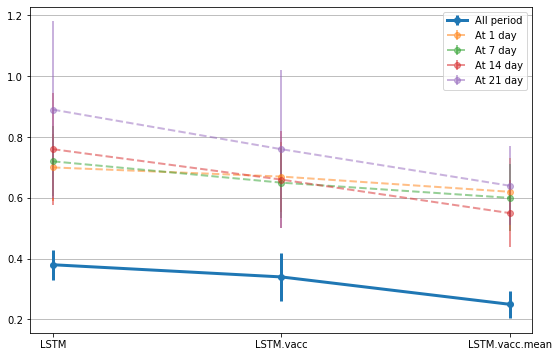

In [235]:
y = pvt.mean(axis=1).round(2).reset_index(drop=False)
y = pd.DataFrame(y)
y["score"] = y[0]
y["cls"][y["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
y.sort_values("cls",inplace=True)
yAll = y[y["dayPred"]==-1]
y1 = y[y["dayPred"]==1]
y7 = y[y["dayPred"]==7]
y14 = y[y["dayPred"]==14]
y21 = y[y["dayPred"]==21]

yAll = yAll["score"]
y1 = y1["score"]
y7 = y7["score"]
y14 = y14["score"]
y21 = y21["score"]

error = pvt.std(axis=1).round(2).reset_index(drop=False)
error = pd.DataFrame(error)
error["score"] = error[0]
error["cls"][error["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
error.sort_values("cls",inplace=True)
errorAll = error[error["dayPred"]==-1]
error1 = error[error["dayPred"]==1]
error7 = error[error["dayPred"]==7]
error14 = error[error["dayPred"]==14]
error21 = error[error["dayPred"]==21]

errorAll = errorAll["score"]
error1 = error1["score"]
error7 = error7["score"]
error14 = error14["score"]
error21 = error21["score"]

plt.figure(figsize=(9,6))
plt.errorbar(range(len(yAll)), yAll, errorAll/2., label="All period", linestyle='-', marker='o', linewidth=3)
plt.errorbar(range(len(y1)), y1, error1/2., label="At 1 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y7)), y7, error7/2., label="At 7 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y14)), y14, error14/2., label="At 14 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y21)), y21, error21/2., label="At 21 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)

plt.xticks(range(len(yAll)),["LSTM","LSTM.vacc","LSTM.vacc.mean"])
#plt.ylim(0,1)
plt.legend()
plt.grid(axis='y')
plt.show()

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

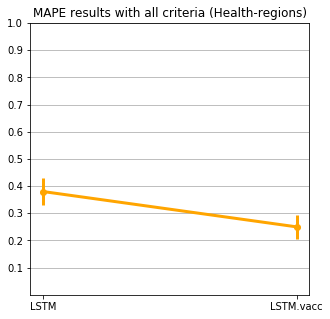

In [43]:
y = pvt.mean(axis=1).round(2).reset_index(drop=False)
y = pd.DataFrame(y)
y["score"] = y[0]
y["cls"][y["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
y.sort_values("cls",inplace=True)
yAll = y[y["dayPred"]==-1]
yAll = yAll["score"]
yAll = yAll.iloc[[0,2]]

error = pvt.std(axis=1).round(2).reset_index(drop=False)
error = pd.DataFrame(error)
error["score"] = error[0]
error["cls"][error["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
error.sort_values("cls",inplace=True)
errorAll = error[error["dayPred"]==-1]
errorAll = errorAll["score"]
errorAll = errorAll.iloc[[0,2]]

plt.figure(figsize=(5,5))
plt.errorbar(range(len(yAll)), yAll, errorAll/2., label="All", linestyle='-', marker='o', linewidth=3, c="orange")
plt.xticks(range(len(yAll)),["LSTM","LSTM.vacc"])
plt.title("MAPE results with all criteria (Health-regions)")
plt.grid(axis='y')
plt.yticks([0.1*i for i in range(1,11)])
plt.ylim(0,1)
plt.show()

In [282]:
grp = dfPerf[dfPerf["dayPred"]==-1][["cls","dayPred","region","mape","mape_s"]].groupby(["cls","region"]).agg(["mean","std"]).reset_index()
grp["mape_m"] = grp["mape"]["mean"]
grp["mape_m"] = grp["mape_m"].astype(float)
grp["mape_std"] = grp["mape_s"]["mean"]
grp["mape_std"] = grp["mape_std"].astype(float)
pvt = pd.pivot(grp, index=["cls"],columns="region",values="mape_m")
display(pvt.iloc[1])
pvt = pd.pivot(grp, index=["cls"],columns="region",values="mape_std")
display(pvt.iloc[1])

region
6100    0.20
6200    0.17
6300    0.19
6400    0.30
6700    0.27
7100    0.41
7801    0.37
7802    0.16
7803    0.21
Name: ingressos_total_best_model_region_vacc_mean7.02122021., dtype: float64

region
6100    0.10
6200    0.12
6300    0.26
6400    0.22
6700    0.14
7100    0.18
7801    0.25
7802    0.09
7803    0.18
Name: ingressos_total_best_model_region_vacc_mean7.02122021., dtype: float64

In [291]:
grp = dfPerf[dfPerf["dayPred"]==-1][["cls","dayPred","region","r2"]].groupby(["cls","region"]).agg(["mean","std"]).reset_index()
grp["r2_m"] = grp["r2"]["mean"]
grp["r2_m"] = grp["r2_m"].astype(float)
pvt = pd.pivot(grp, index=["cls"],columns="region",values="r2_m")
display(pvt.iloc[1])

region
6100    0.94
6200    0.85
6300    0.49
6400    0.72
6700    0.90
7100   -0.13
7801    0.92
7802    0.94
7803    0.88
Name: ingressos_total_best_model_region_vacc_mean7.02122021., dtype: float64

In [292]:
grp = dfPerf[dfPerf["dayPred"]==-1][["cls","dayPred","region","mae","mae_s"]].groupby(["cls","region"]).agg(["mean"]).reset_index()
grp["mae_m"] = grp["mae"]["mean"]
grp["mae_m"] = grp["mae_m"].astype(float)
grp["mae_std"] = grp["mae_s"]["mean"]
grp["mae_std"] = grp["mae_std"].astype(float)
pvt = pd.pivot(grp, index=["cls"],columns="region",values="mae_m")
display(pvt.iloc[1])
pvt_s = pd.pivot(grp, index=["cls"],columns="region",values="mae_std")
display(pvt_s.iloc[1])

region
6100    0.80
6200    0.77
6300    0.27
6400    2.24
6700    2.74
7100    0.49
7801    2.10
7802    2.21
7803    1.44
Name: ingressos_total_best_model_region_vacc_mean7.02122021., dtype: float64

region
6100    0.61
6200    0.65
6300    0.31
6400    2.06
6700    1.69
7100    0.23
7801    1.08
7802    1.41
7803    1.25
Name: ingressos_total_best_model_region_vacc_mean7.02122021., dtype: float64

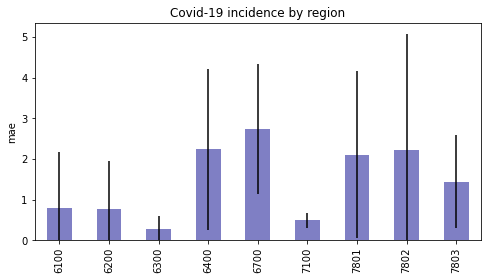

In [293]:
pvt.iloc[1].plot(kind='bar',figsize=(8,4),color="darkblue",alpha=0.5,yerr=pvt_s.iloc[2])
plt.ylim(0,)
plt.ylabel("mae")
#plt.axhline(0.5,ls="--",c="black",linewidth=0.5)
plt.axhline(0.,ls="-",c="black",linewidth=1)
#plt.axhline(-0.5,ls="--",c="black",linewidth=0.5)
plt.title("Covid-19 incidence by region")
plt.xlabel("")
plt.show()

In [88]:
grp = dfPerf[["cls","dayPred","r2"]].groupby(["cls","dayPred"]).agg(["mean","std"]).reset_index()
grp["r2_m"] = grp["r2"]["mean"]
grp["r2_m"] = grp["r2_m"].astype(float)
pvt = pd.pivot(grp, index="cls",columns="dayPred",values="r2_m")
display(pvt)
display(pvt.mean(axis=1))
display(pvt.std(axis=1))

dayPred,-1,1,7,14,21
cls,,,,,
ingressos_total_best_model_region_vacc_mean7.02122021.,0.727778,0.571111,0.568889,0.523333,0.484444


cls
ingressos_total_best_model_region_vacc_mean7.02122021.    0.575111
dtype: float64

cls
ingressos_total_best_model_region_vacc_mean7.02122021.    0.092552
dtype: float64

([<matplotlib.axis.XTick at 0x14632bff2128>], [Text(0, 0, 'LSTM_VACC_MEAN')])

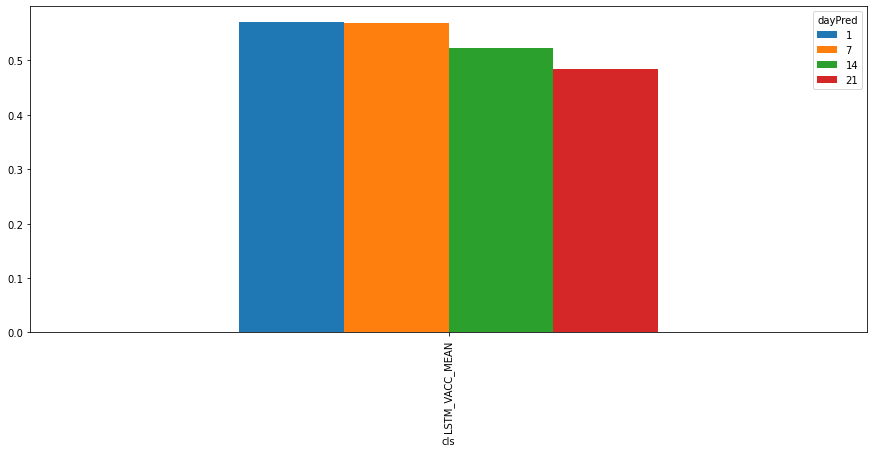

In [89]:
pvt.iloc[[0],1:].plot(kind='bar',figsize=(15,6))
plt.xticks(range(1),["LSTM_VACC_MEAN"])